# Ant Colony Optimization Algorithm for Sequential Ordering Problem

In [10]:
import os
import random
import time
import numpy as np
from collections import defaultdict
from pathlib import Path
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt


## The Sequential Ordering Problem


In [11]:
class SOP:
    def __init__(self, file_path):
        """Initialize SOP problem from a file path"""
        self.file_path = file_path
        self.file_name = Path(file_path).name
        self.nodes, self.costs, self.precedence = self.parse_file(file_path)
        self.size = len(self.nodes)
        # Create precedence graph for faster validation
        self.before = defaultdict(set)
        self.after = defaultdict(set)
        self.build_precedence_graph()

    def parse_file(self, file_path):
        """Parse SOP file format"""
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Extract dimension
        dimension = next(int(line.strip().split(':')[1]) 
                         for line in lines if line.startswith('DIMENSION'))
        
        # Find the start of matrix data
        matrix_start = next(i for i, line in enumerate(lines) 
                           if line.startswith('EDGE_WEIGHT_SECTION')) + 1
        
        # Skip the dimension line if present
        if lines[matrix_start].strip().isdigit():
            matrix_start += 1
        
        # Parse the matrix
        matrix_data = []
        for i in range(matrix_start, matrix_start + dimension):
            row = list(map(int, lines[i].strip().split()))
            matrix_data.append(row)
        
        # Convert to numpy array for faster operations
        costs_matrix = np.array(matrix_data)
        
        # Extract nodes and costs
        nodes = list(range(1, dimension + 1))
        costs = {}
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] != -1:
                    costs[(i+1, j+1)] = costs_matrix[i, j]
        
        # Extract precedence constraints (wherever there's a -1)
        precedence = []
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] == -1 and i != j:
                    precedence.append((j+1, i+1))  # j must come before i
        
        return nodes, costs, precedence

    def build_precedence_graph(self):
        """Build precedence graph for faster validation"""
        for u, v in self.precedence:
            self.before[v].add(u)
            self.after[u].add(v)
        
        # Transitive closure - if a→b and b→c then a→c
        changed = True
        while changed:
            changed = False
            for node in self.nodes:
                old_before = self.before[node].copy()
                for b in old_before:
                    self.before[node].update(self.before[b])
                if len(self.before[node]) > len(old_before):
                    changed = True
                    
                old_after = self.after[node].copy()
                for a in old_after:
                    self.after[node].update(self.after[a])
                if len(self.after[node]) > len(old_after):
                    changed = True

    def is_valid(self, path):
        """Check if a path is valid according to precedence constraints"""
        position = {node: i for i, node in enumerate(path)}
        
        # Check precedence constraints
        for i, node in enumerate(path):
            for before_node in self.before[node]:
                if before_node in position and position[before_node] >= i:
                    return False
                    
        # Check if costs exist between adjacent nodes
        for i in range(len(path) - 1):
            if (path[i], path[i+1]) not in self.costs:
                return False
                
        return True

    def total_cost(self, path):
        """Calculate total cost of a path"""
        return sum(self.costs.get((path[i], path[i+1]), float('inf')) 
                  for i in range(len(path) - 1))

# Ant Colony Optimization Implementation


Processing ESC07.sop...
Iteration 0/100, Best cost: 2825
Iteration 10/100, Best cost: 2475
Iteration 20/100, Best cost: 2475
Iteration 30/100, Best cost: 2475
Iteration 40/100, Best cost: 2475
Iteration 50/100, Best cost: 2475
Iteration 60/100, Best cost: 2475
Iteration 70/100, Best cost: 2475
Iteration 80/100, Best cost: 2475
Iteration 90/100, Best cost: 2475
Iteration 99/100, Best cost: 2475

Solution for ESC07.sop:
Path: [1, 2, 3, 5, 8, 7, 6, 4, 9]
Cost: 2475
Time: 0.23 seconds

Processing ESC11.sop...
Iteration 0/100, Best cost: 2496
Iteration 10/100, Best cost: 2453
Iteration 20/100, Best cost: 2453
Iteration 30/100, Best cost: 2453
Iteration 40/100, Best cost: 2453
Iteration 50/100, Best cost: 2453
Iteration 60/100, Best cost: 2453
Iteration 70/100, Best cost: 2453
Iteration 80/100, Best cost: 2453
Iteration 90/100, Best cost: 2453
Iteration 99/100, Best cost: 2453

Solution for ESC11.sop:
Path: [1, 2, 9, 12, 3, 4, 7, 11, 8, 5, 6, 10, 13]
Cost: 2453
Time: 0.43 seconds

Processin

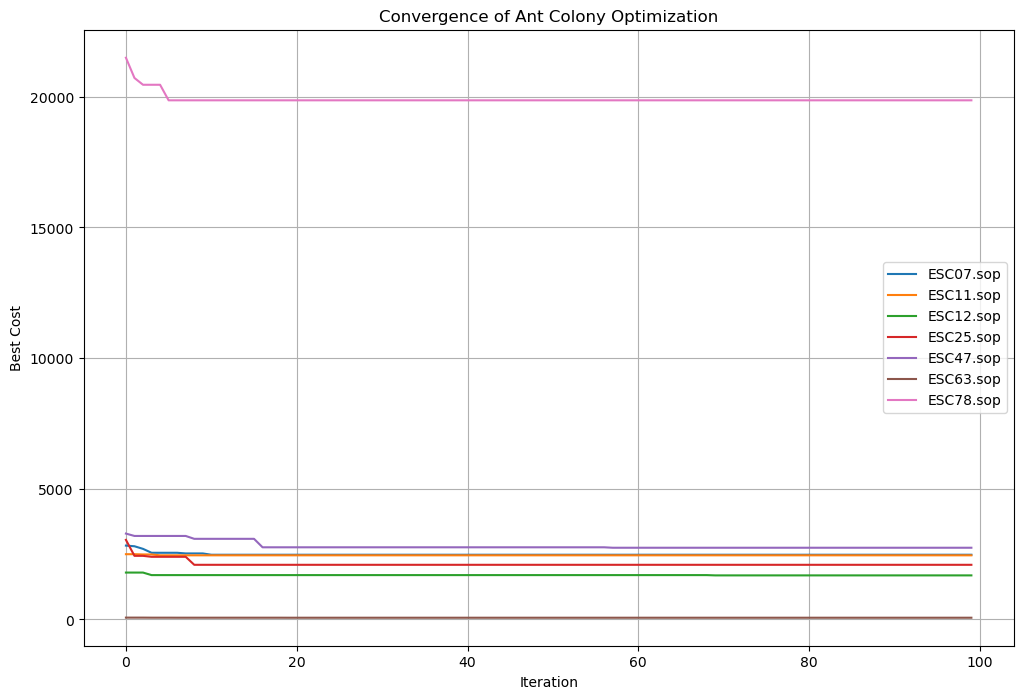

In [12]:
class AntColonySolver:
    def __init__(self, sop, ants=50, iterations=100, 
                 alpha=1.0, beta=2.0, rho=0.1, q0=0.9,
                 initial_pheromone=0.1, local_decay=0.1):
        """
        Initialize ACO solver for Sequential Ordering Problem
        
        Parameters:
        - sop: SOP class instance with problem data
        - ants: number of ants per iteration
        - iterations: number of iterations to run
        - alpha: relative importance of pheromone
        - beta: relative importance of heuristic information
        - rho: pheromone evaporation rate
        - q0: probability of exploitation (vs exploration)
        - initial_pheromone: initial pheromone value
        - local_decay: local pheromone decay parameter
        """
        self.sop = sop
        self.ants = ants
        self.iterations = iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q0 = q0
        self.initial_pheromone = initial_pheromone
        self.local_decay = local_decay
        
        # Initialize pheromone matrix
        self.pheromone = {}
        for i in self.sop.nodes:
            for j in self.sop.nodes:
                if (i, j) in self.sop.costs:
                    self.pheromone[(i, j)] = initial_pheromone
        
        # Heuristic information (inverse of cost)
        self.heuristic = {}
        for (i, j), cost in self.sop.costs.items():
            self.heuristic[(i, j)] = 1.0 / cost if cost > 0 else 0.0
        
        # Best solution tracking
        self.best_solution = None
        self.best_cost = float('inf')
        self.iteration_stats = []
    
    def construct_solution(self):
        """
        Construct a solution for a single ant using the ACO approach
        with precedence constraints
        """
        # Start with a valid starting node
        unvisited = set(self.sop.nodes)
        current_path = []
        
        # Find valid starting nodes (with no predecessors)
        valid_starts = [n for n in self.sop.nodes if not self.sop.before[n]]
        start_node = valid_starts[0] if valid_starts else 1
        
        current_node = start_node
        current_path.append(current_node)
        unvisited.remove(current_node)
        
        # Continue until all nodes are visited
        while unvisited:
            # Find feasible next nodes (those with all predecessors visited)
            feasible_nodes = []
            for node in unvisited:
                if all(pred not in unvisited for pred in self.sop.before[node]):
                    if (current_node, node) in self.sop.costs:
                        feasible_nodes.append(node)
            
            # If no feasible next nodes, we have a problem with the instance
            if not feasible_nodes:
                # Fallback strategy: choose any unvisited node
                for node in unvisited:
                    if (current_node, node) in self.sop.costs:
                        feasible_nodes.append(node)
                
                # If still no feasible nodes, choose any node
                if not feasible_nodes:
                    feasible_nodes = list(unvisited)
            
            # Apply ACO selection rule
            next_node = self.select_next_node(current_node, feasible_nodes)
            
            # Apply local pheromone update
            self.local_pheromone_update(current_node, next_node)
            
            # Move to next node
            current_path.append(next_node)
            current_node = next_node
            unvisited.remove(next_node)
        
        # Verify the path is valid
        if not self.sop.is_valid(current_path):
            current_path = self.repair_path(current_path)
            
        return current_path
    
    def select_next_node(self, current_node, feasible_nodes):
        """
        Select next node using ACO transition rule
        """
        if not feasible_nodes:
            return None
            
        # Exploitation (choose best) or exploration (probabilistic)
        if random.random() < self.q0:
            # Exploitation - choose best node
            return max(feasible_nodes, 
                      key=lambda j: self.pheromone.get((current_node, j), 0) ** self.alpha * 
                                   self.heuristic.get((current_node, j), 0) ** self.beta)
        else:
            # Exploration - probabilistic choice
            total = 0
            probabilities = []
            
            for node in feasible_nodes:
                prob = (self.pheromone.get((current_node, node), 0) ** self.alpha * 
                       self.heuristic.get((current_node, node), 0) ** self.beta)
                probabilities.append(prob)
                total += prob
            
            # Normalize probabilities
            if total > 0:
                probabilities = [p/total for p in probabilities]
            else:
                # If all probabilities are zero, use uniform distribution
                probabilities = [1.0/len(feasible_nodes)] * len(feasible_nodes)
            
            # Roulette wheel selection
            r = random.random()
            cumulative = 0
            for i, prob in enumerate(probabilities):
                cumulative += prob
                if r <= cumulative:
                    return feasible_nodes[i]
            
            # Fallback
            return random.choice(feasible_nodes)
    
    def local_pheromone_update(self, i, j):
        """
        Apply local pheromone update rule
        τ(i,j) = (1-ξ) * τ(i,j) + ξ * τ0
        """
        if (i, j) in self.pheromone:
            self.pheromone[(i, j)] = ((1 - self.local_decay) * self.pheromone[(i, j)] + 
                                     self.local_decay * self.initial_pheromone)
    
    def global_pheromone_update(self, best_path, best_cost):
        """
        Apply global pheromone update rule
        τ(i,j) = (1-ρ) * τ(i,j) + ρ * Δτ(i,j)
        where Δτ(i,j) = 1/L if (i,j) belongs to best path, 0 otherwise
        """
        # Evaporation
        for i, j in self.pheromone:
            self.pheromone[(i, j)] *= (1 - self.rho)
        
        # Reinforcement for best path
        for i in range(len(best_path) - 1):
            edge = (best_path[i], best_path[i+1])
            if edge in self.pheromone:
                delta = 1.0 / best_cost if best_cost > 0 else 0
                self.pheromone[edge] += self.rho * delta
    
    def repair_path(self, path):
        """
        Repair a path to satisfy precedence constraints
        """
        # Create a valid ordering based on precedence constraints
        valid_path = []
        nodes_to_place = set(path)
        
        while nodes_to_place:
            # Find nodes with all precedence constraints satisfied
            valid_candidates = [n for n in nodes_to_place 
                              if all(pred in valid_path for pred in self.sop.before[n])]
            
            # If no valid candidates, there's a cycle - break it
            if not valid_candidates:
                # Choose a node arbitrarily
                next_node = next(iter(nodes_to_place))
            else:
                # Choose a node with the earliest position in the original path
                next_node = min(valid_candidates, key=lambda n: path.index(n))
            
            valid_path.append(next_node)
            nodes_to_place.remove(next_node)
            
        return valid_path
    
    def solve(self, verbose=True):
        """
        Main solving method for the ACO algorithm
        """
        start_time = time.time()
        
        # Iterations of the ACO algorithm
        for it in range(self.iterations):
            iteration_best_cost = float('inf')
            iteration_best_path = None
            
            # Each ant constructs a solution
            for ant in range(self.ants):
                # Construct solution
                path = self.construct_solution()
                cost = self.sop.total_cost(path)
                
                # Update iteration best
                if cost < iteration_best_cost:
                    iteration_best_cost = cost
                    iteration_best_path = path.copy()
            
            # Update global best
            if iteration_best_cost < self.best_cost:
                self.best_cost = iteration_best_cost
                self.best_solution = iteration_best_path.copy()
            
            # Global pheromone update
            self.global_pheromone_update(self.best_solution, self.best_cost)
            
            # Record statistics
            self.iteration_stats.append({
                'iteration': it,
                'best_cost': self.best_cost,
                'iteration_best': iteration_best_cost,
                'avg_cost': iteration_best_cost  # Can be improved with multiple ants
            })
            
            # Display progress
            if verbose and (it % 10 == 0 or it == self.iterations - 1):
                print(f"Iteration {it}/{self.iterations}, Best cost: {self.best_cost}")
        
        end_time = time.time()
        
        if verbose:
            print(f"\nSolution for {self.sop.file_name}:")
            print(f"Path: {self.best_solution}")
            print(f"Cost: {self.best_cost}")
            print(f"Time: {end_time - start_time:.2f} seconds")
        
        return {
            'instance': self.sop.file_name,
            'solution': self.best_solution,
            'cost': self.best_cost,
            'time': end_time - start_time,
            'iterations': self.iterations,
            'stats': self.iteration_stats
        }

## Running the Algorithm

def solve_instance(file_path, ants=50, iterations=100, verbose=False):
    """Solve a single SOP instance with ACO"""
    sop = SOP(file_path)
    solver = AntColonySolver(sop, ants=ants, iterations=iterations)
    result = solver.solve(verbose=verbose)
    return result

## Processing Multiple Instances

def process_all_instances(data_dir="ACO-SOP/data/", 
                          instance_names=None, 
                          ants=50,
                          iterations=100,
                          parallel=False,
                          verbose=True):
    """Process multiple SOP instances with ACO"""
    if instance_names is None:
        instance_names = ["ESC07", "ESC11", "ESC12", "ESC25", "ESC47", "ESC63", "ESC78"]
    
    # Construct file paths
    file_paths = [os.path.join(data_dir, f"{name}.sop") for name in instance_names]
    
    # Check that all files exist
    for path in file_paths:
        if not os.path.exists(path):
            print(f"Warning: File {path} not found!")
    
    # Filter to only existing files
    file_paths = [path for path in file_paths if os.path.exists(path)]
    
    if not file_paths:
        raise FileNotFoundError("No valid SOP files found!")
    
    results = {}
    
    if parallel and len(file_paths) > 1:
        # Process in parallel using multiple cores
        print(f"Processing {len(file_paths)} instances in parallel...")
        with multiprocessing.Pool() as pool:
            # Create arguments for each instance
            args = [(path, ants, iterations, False) for path in file_paths]
            parallel_results = pool.starmap(solve_instance, args)
            
            # Organize results by instance name
            for result in parallel_results:
                results[result['instance']] = result
    else:
        # Process sequentially
        for path in file_paths:
            if verbose:
                print(f"\n{'='*50}")
                print(f"Processing {os.path.basename(path)}...")
                print(f"{'='*50}")
            
            result = solve_instance(path, ants, iterations, verbose)
            results[result['instance']] = result
    
    # Print summary
    if verbose:
        print("\n" + "="*70)
        print("Summary of Results:")
        print("="*70)
        print(f"{'Instance':<10} | {'Cost':>10} | {'Time (s)':>10} | {'Iterations':>12}")
        print("-"*70)
        for name, result in results.items():
            print(f"{name:<10} | {result['cost']:>10.2f} | {result['time']:>10.2f} | {result['iterations']:>12}")
    
    return results

## Saving Results

import os
import pandas as pd
import matplotlib.pyplot as plt

def save_results(results, output_dir="resultsACO"):
    """Save ACO results into resultsACO/ with the naming you showed."""
    os.makedirs(output_dir, exist_ok=True)

    # summary CSV
    summary = []
    for name, res in results.items():
        summary.append({
            "instance":   name,
            "cost":       res["cost"],
            "time":       res["time"],
            "iterations": res["iterations"]
        })
    pd.DataFrame(summary).to_csv(
        os.path.join(output_dir, "aco_summary.csv"), index=False
    )

    # each instance: solution + stats
    for name, res in results.items():
        # .sop_solution.txt
        with open(os.path.join(output_dir, f"{name}.sop_solution.txt"), "w") as f:
            f.write(f"Instance: {name}\n")
            f.write(f"Path: {res['solution']}\n")
            f.write(f"Cost: {res['cost']}\n")
            f.write(f"Time: {res['time']:.2f} sec\n")

        # .sop_stats.csv
        pd.DataFrame(res["stats"]).to_csv(
            os.path.join(output_dir, f"{name}.sop_stats.csv"), index=False
        )

    # convergence plot
    plt.figure(figsize=(10,6))
    for name, res in results.items():
        df = pd.DataFrame(res["stats"])
        plt.plot(df["iteration"], df["best_cost"], label=name)
    plt.xlabel("Iteration")
    plt.ylabel("Best Cost")
    plt.title("ACO Convergence")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "aco_convergence_plot.png"))
    plt.close()

    print(f"All files written to ./{output_dir}/")

# … down at the bottom of your script, after you call process_all_instances(…) …

if __name__ == "__main__":
    results = process_all_instances(
        data_dir="../data",
        instance_names=instances,
        ants=50,
        iterations=100,
        parallel=False,
        verbose=True
    )
    # add this line to write into resultsACO/
    save_results(results, output_dir="resultsACO")

def plot_convergence(results):
    """Plot convergence of ACO algorithm for multiple instances"""
    plt.figure(figsize=(12, 8))
    
    for name, result in results.items():
        stats = pd.DataFrame(result['stats'])
        plt.plot(stats['iteration'], stats['best_cost'], label=name)
    
    plt.xlabel('Iteration')
    plt.ylabel('Best Cost')
    plt.title('Convergence of Ant Colony Optimization')
    plt.legend()
    plt.grid(True)
    plt.savefig('./results/aco_convergence_plot.png')
    plt.show()

# Plot convergence from results if this script is run directly
if __name__ == "__main__":
    plot_convergence(results)